<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/28/hmm_gauss2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM with 2d Gaussian emissions 

We use the [ssm-jax](https://github.com/probml/ssm-jax/blob/main/ssm_jax/) library
to two algorithms for fitting a Gaussian HMM:
1. (Batch) EM
2. Stochastic EM

In [1]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

from ssm_jax.hmm.models import GaussianHMM
import ssm_jax.hmm.demos.gaussian_hmm_2d as demo

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import matplotlib.pyplot as plt

/home/libi/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

**Generate sample data**

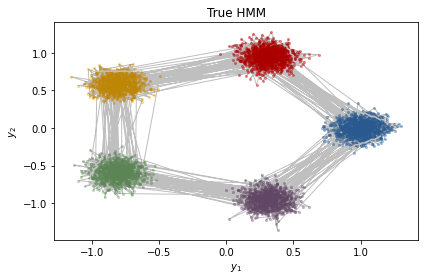

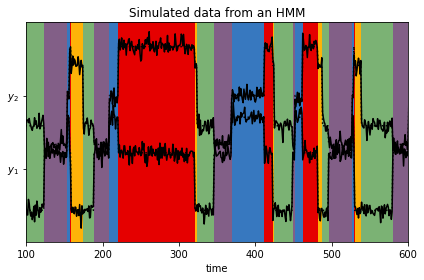

In [8]:
num_batches = 9
num_timesteps = 5000

# Make an HMM and sample data and true underlying states
true_hmm = demo.make_hmm()
batch_true_states, batch_emissions = \
    vmap(true_hmm.sample, in_axes=(0, None))(jr.split(jr.PRNGKey(0), num_batches), num_timesteps)

i_batch = 0
# Plot emissions and true_states in the emissions plane
demo.plot_gaussian_hmm(true_hmm, batch_emissions[0], batch_true_states[0], "True HMM");

# Plot emissions vs. time, ith background colored by true state
demo.plot_gaussian_hmm_data(true_hmm, batch_emissions[0], batch_true_states[0], xlim=(100, 600));

**Initialize test HMMs and fit to data**

Fitting via exact EM...


100%|██████████| 50/50 [00:05<00:00,  9.86it/s]



Fitting via stochastic EM (no progress bar)...
	Done


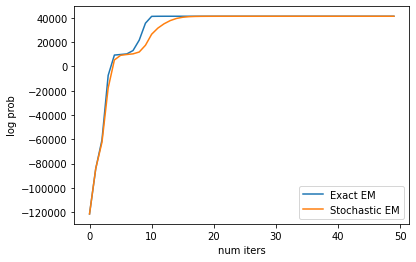

In [9]:
# Initialize HMMs, with inexact number of states
hmm_exact = GaussianHMM.random_initialization(
    jr.PRNGKey(1), true_hmm.num_states, true_hmm.num_obs
)
hmm_stoch = GaussianHMM.random_initialization(
    jr.PRNGKey(1), true_hmm.num_states, true_hmm.num_obs
)

# Fit
num_iters = 50

print('Fitting via exact EM...')
lps_exact = hmm_exact.fit_em(batch_emissions, num_iters)

print()
print('Fitting via stochastic EM (no progress bar)...')
lps_stoch = hmm_stoch.fit_stochastic_em(
    batch_emissions, batch_size=len(batch_emissions//3), num_epochs=num_iters, key=jr.PRNGKey(2),
)
print('\tDone')

# Plot log probs vs num_iterations
plt.plot(jnp.arange(len(lps_exact)), lps_exact, label='Exact EM')
plt.plot(jnp.arange(len(lps_stoch)), lps_stoch, label='Stochastic EM')
plt.xlabel('num iters')
plt.ylabel('log prob')
plt.legend();

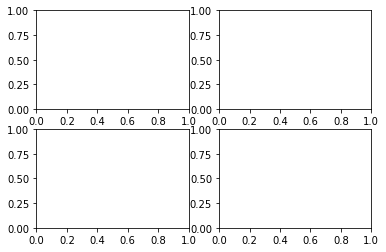

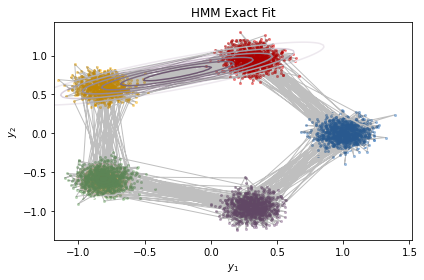

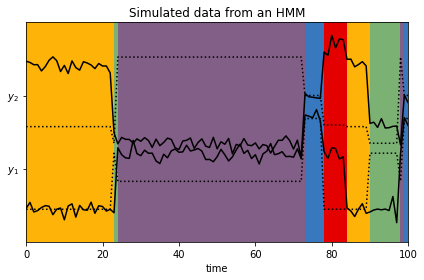

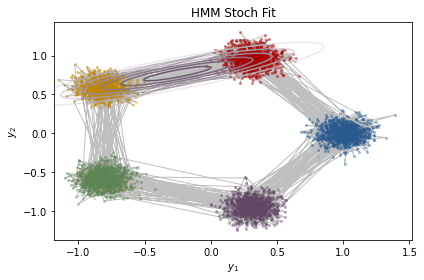

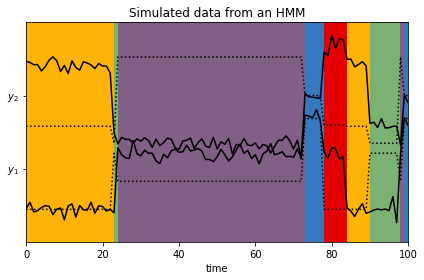

In [12]:
# TODO Recompute once we've implemented k-means initialization
# TODO plotting functions need to be able to permute

i_batch = 5

fig, axarr = plt.subplots(nrows=2, ncols=2)

demo.plot_gaussian_hmm(hmm_exact, batch_emissions[i_batch], batch_true_states[i_batch], "HMM Exact Fit")
demo.plot_gaussian_hmm_data(hmm_exact, batch_emissions[i_batch], batch_true_states[i_batch], xlim=(0, 100))

demo.plot_gaussian_hmm(hmm_stoch, batch_emissions[i_batch], batch_true_states[i_batch], "HMM Stoch Fit");
demo.plot_gaussian_hmm_data(hmm_stoch, batch_emissions[i_batch], batch_true_states[i_batch], xlim=(0, 100));